# Scalability on PSFC GPU

In [1]:
import matplotlib.pyplot as plt
import json 

In [3]:
import json
import argparse
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

class ScalingPlotter:
    def __init__(self):
        self.models = {}
        self.markers = ['o', 's', '^', 'D', 'v', '<', '>']
        self.colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
        
    def add_model(self, name: str, json_path: str):
        """Load a model's data from a JSON file."""
        with open(json_path, 'r') as f:
            self.models[name] = json.load(f)
            
    def extract_gpu_counts(self, data_dict):
        """Extract GPU counts from gpus_X keys."""
        return [int(k.split('_')[1]) for k in data_dict.keys()]
        
    def plot_strong_scaling(self, 
                          atom_count=None,  # If None, plot all atom counts for one model
                          model_name=None,  # If None, plot all models for one atom count
                          metric='timesteps_per_second',
                          separate_plots=False,
                          output_path=None):
        """
        Plot strong scaling results.
        If atom_count specified: Compare different models for that atom count
        If model_name specified: Compare different atom counts for that model
        """
        plt.figure(figsize=(10, 6))
        
        if model_name and atom_count:
            raise ValueError("Specify either model_name or atom_count, not both")
            
        if model_name:  # Plot different atom counts for one model
            data = self.models[model_name]['strong_scaling']
            for i, (atoms_key, atoms_data) in enumerate(data.items()):
                gpu_counts = self.extract_gpu_counts(atoms_data)
                values = [atoms_data[f'gpus_{gpu}'][metric] for gpu in gpu_counts]
                
                if separate_plots:
                    plt.figure(figsize=(10, 6))
                    
                plt.plot(gpu_counts, values, f'-{self.markers[i]}', 
                        label=f'{atoms_key}', color=self.colors[i])
                
                if separate_plots:
                    plt.title(f'Strong Scaling - {model_name}\n{atoms_key}')
                    plt.xlabel('Number of GPUs')
                    plt.ylabel(metric.replace('_', ' ').title())
                    plt.grid(True)
                    plt.legend()
                    if output_path:
                        plt.savefig(f'{output_path}_{atoms_key}.png')
                    plt.close()
                    
        else:  # Plot different models for one atom count
            for i, (model_name, model_data) in enumerate(self.models.items()):
                if atom_count not in model_data['strong_scaling']:
                    continue
                    
                atoms_data = model_data['strong_scaling'][atom_count]
                gpu_counts = self.extract_gpu_counts(atoms_data)
                values = [atoms_data[f'gpus_{gpu}'][metric] for gpu in gpu_counts]
                
                plt.plot(gpu_counts, values, f'-{self.markers[i]}', 
                        label=f'{model_name}', color=self.colors[i])
                
        if not separate_plots:
            title = f'Strong Scaling - {model_name if model_name else atom_count}'
            plt.title(title)
            plt.xlabel('Number of GPUs')
            plt.ylabel(metric.replace('_', ' ').title())
            plt.grid(True)
            plt.legend()
            if output_path:
                plt.savefig(f'{output_path}.png')
            plt.show()
            
    def plot_weak_scaling(self,
                         atoms_per_gpu=None,  # If None, plot all atoms_per_gpu for one model
                         model_name=None,  # If None, plot all models for one atoms_per_gpu
                         metric='timesteps_per_second',
                         separate_plots=False,
                         output_path=None):
        """
        Plot weak scaling results, normalized to single GPU performance.
        If atoms_per_gpu specified: Compare different models for that configuration
        If model_name specified: Compare different atoms_per_gpu for that model
        """
        plt.figure(figsize=(10, 6))
        
        if model_name and atoms_per_gpu:
            raise ValueError("Specify either model_name or atoms_per_gpu, not both")
            
        if model_name:  # Plot different atoms_per_gpu for one model
            data = self.models[model_name]['weak_scaling']
            for i, (atoms_key, atoms_data) in enumerate(data.items()):
                gpu_counts = self.extract_gpu_counts(atoms_data)
                base_value = atoms_data['gpus_1'][metric]
                values = [atoms_data[f'gpus_{gpu}'][metric]/base_value for gpu in gpu_counts]
                
                if separate_plots:
                    plt.figure(figsize=(10, 6))
                    
                plt.plot(gpu_counts, values, f'-{self.markers[i]}', 
                        label=f'{atoms_key}', color=self.colors[i])
                
                if separate_plots:
                    plt.title(f'Weak Scaling - {model_name}\n{atoms_key}')
                    plt.xlabel('Number of GPUs')
                    plt.ylabel(f'Normalized {metric.replace("_", " ").title()}')
                    plt.grid(True)
                    plt.legend()
                    if output_path:
                        plt.savefig(f'{output_path}_{atoms_key}.png')
                    plt.close()
                    
        else:  # Plot different models for one atoms_per_gpu
            for i, (model_name, model_data) in enumerate(self.models.items()):
                if atoms_per_gpu not in model_data['weak_scaling']:
                    continue
                    
                atoms_data = model_data['weak_scaling'][atoms_per_gpu]
                gpu_counts = self.extract_gpu_counts(atoms_data)
                base_value = atoms_data['gpus_1'][metric]
                values = [atoms_data[f'gpus_{gpu}'][metric]/base_value for gpu in gpu_counts]
                
                plt.plot(gpu_counts, values, f'-{self.markers[i]}', 
                        label=f'{model_name}', color=self.colors[i])
                
        if not separate_plots:
            title = f'Weak Scaling - {model_name if model_name else atoms_per_gpu}'
            plt.title(title)
            plt.xlabel('Number of GPUs')
            plt.ylabel(f'Normalized {metric.replace("_", " ").title()}')
            plt.grid(True)
            plt.legend()
            if output_path:
                plt.savefig(f'{output_path}.png')
            plt.show()

"""

def main():
    
    parser = argparse.ArgumentParser(description='Generate scaling plots from LAMMPS results')
    parser.add_argument('--models', nargs='+', help='Model JSON files in format name:path')
    parser.add_argument('--plot-type', choices=['strong', 'weak'], required=True)
    parser.add_argument('--metric', default='timesteps_per_second', 
                       choices=['ns_per_day', 'hours_per_ns', 'timesteps_per_second', 'katom_steps_per_second'])
    parser.add_argument('--separate', action='store_true', help='Generate separate plots')
    parser.add_argument('--model-name', help='Plot different sizes for this model')
    parser.add_argument('--atom-count', help='For strong scaling: plot different models for this atom count')
    parser.add_argument('--atoms-per-gpu', help='For weak scaling: plot different models for this atoms_per_gpu')
    parser.add_argument('--output', help='Output path for plots (without extension)')
    
    args = parser.parse_args()
    
    plotter = ScalingPlotter()
    
    # Load all model data
    for model_spec in args.models:
        name, path = model_spec.split(':')
        plotter.add_model(name, path)
    
    if args.plot_type == 'strong':
        plotter.plot_strong_scaling(
            atom_count=args.atom_count,
            model_name=args.model_name,
            metric=args.metric,
            separate_plots=args.separate,
            output_path=args.output
        )
    else:
        plotter.plot_weak_scaling(
            atoms_per_gpu=args.atoms_per_gpu,
            model_name=args.model_name,
            metric=args.metric,
            separate_plots=args.separate,
            output_path=args.output
        )
if __name__ == "__main__":
    main()
    
    
"""

'\n\ndef main():\n    \n    parser = argparse.ArgumentParser(description=\'Generate scaling plots from LAMMPS results\')\n    parser.add_argument(\'--models\', nargs=\'+\', help=\'Model JSON files in format name:path\')\n    parser.add_argument(\'--plot-type\', choices=[\'strong\', \'weak\'], required=True)\n    parser.add_argument(\'--metric\', default=\'timesteps_per_second\', \n                       choices=[\'ns_per_day\', \'hours_per_ns\', \'timesteps_per_second\', \'katom_steps_per_second\'])\n    parser.add_argument(\'--separate\', action=\'store_true\', help=\'Generate separate plots\')\n    parser.add_argument(\'--model-name\', help=\'Plot different sizes for this model\')\n    parser.add_argument(\'--atom-count\', help=\'For strong scaling: plot different models for this atom count\')\n    parser.add_argument(\'--atoms-per-gpu\', help=\'For weak scaling: plot different models for this atoms_per_gpu\')\n    parser.add_argument(\'--output\', help=\'Output path for plots (witho

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


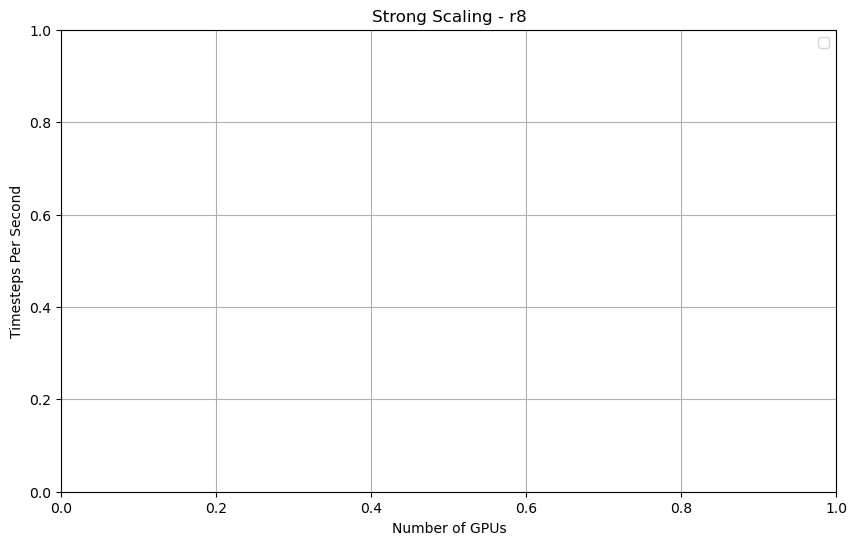

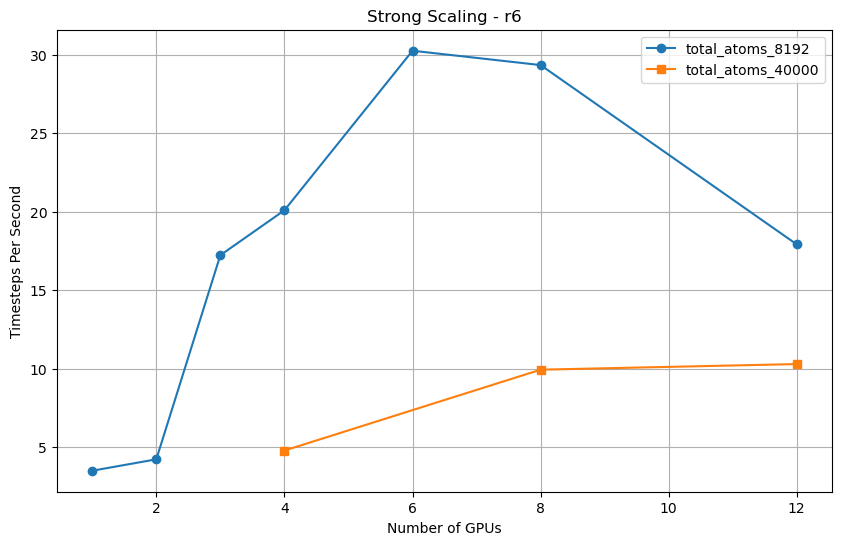

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


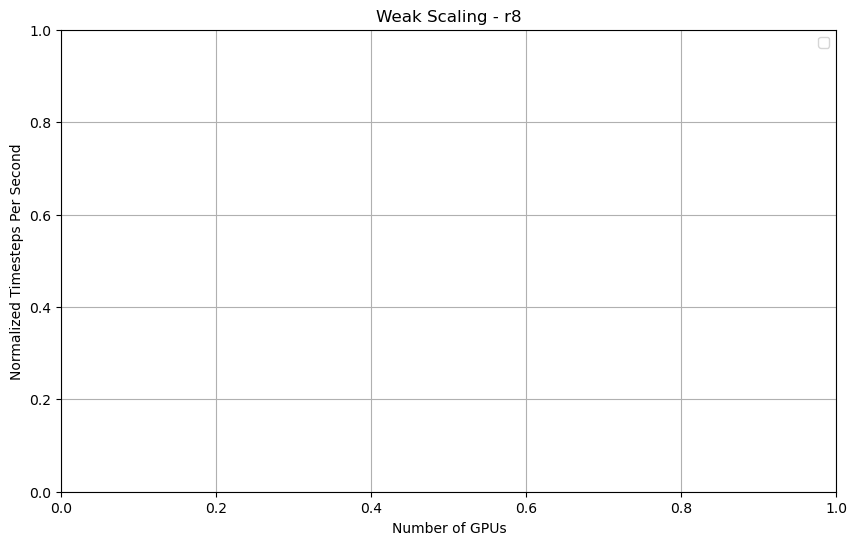

In [5]:
# Initialize the plotter
plotter = ScalingPlotter()

# Define model paths and names
model_paths = {
    'r6': 'data/VCrTiWZr_Scalability_Test/r6_data.json',
    'r7': 'data/VCrTiWZr_Scalability_Test/r7_data.json',
    'r8': 'data/VCrTiWZr_Scalability_Test/r8_data.json'
}

# Load all models
for name, path in model_paths.items():
    plotter.add_model(name, path)

# Example 1: Compare different models for atom count 8192
plotter.plot_strong_scaling(
    atom_count='8192',  # Note: this will look for "total_atoms_8192" in the data
    metric='timesteps_per_second',
    separate_plots=False,
    output_path='strong_scaling_comparison'
)

# Example 2: Compare different atom counts for r6 model
plotter.plot_strong_scaling(
    model_name='r6',
    metric='timesteps_per_second',
    separate_plots=False,
    output_path='r6_strong_scaling'
)

# Example 3: Weak scaling comparison for atoms_per_gpu_1024
plotter.plot_weak_scaling(
    atoms_per_gpu='1024',  # Note: this will look for "atoms_per_gpu_1024" in the data
    metric='timesteps_per_second',
    separate_plots=False,
    output_path='weak_scaling_comparison'
)

[1, 2, 3, 4, 6, 8, 12]
[3.512, 4.238, 17.24, 20.099, 30.263, 29.349, 17.925]
[1, 2, 3, 4, 6, 8, 12]
[1.914, 2.479, 7.034, 11.274, 13.318, 12.106, 16.017]
[1, 2, 3, 4, 6, 8, 12]
[0, 2.292, 2.961, 4.342, 5.735, 6.252, 7.87]


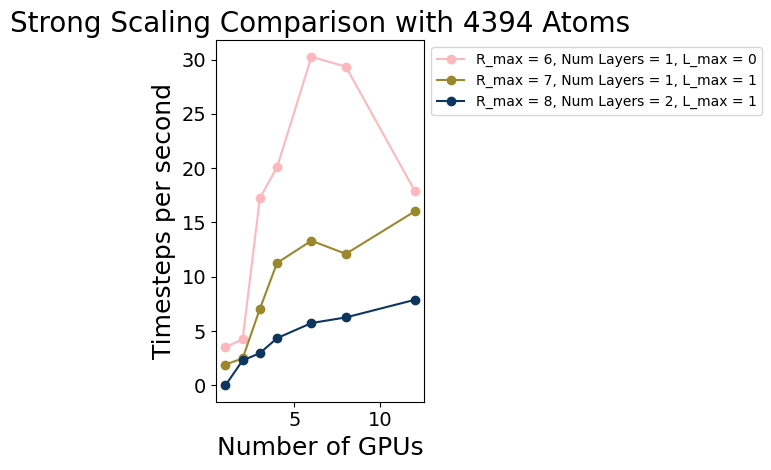

In [10]:
import json
import matplotlib.pyplot as plt

r6_data = json.load(open('data/VCrTiWZr_Scalability_Test/r6_data.json'))
r7_data = json.load(open('data/VCrTiWZr_Scalability_Test/r7_data.json'))
r8_data = json.load(open('data/VCrTiWZr_Scalability_Test/r8_data.json'))

atom_size = 8192 # 8192 or 40000
strong_scaling_r6 = r6_data['strong_scaling'][f'total_atoms_{atom_size}']
num_gpus_r6 = [int(k.split('_')[1]) for k in strong_scaling_r6.keys()]
print(num_gpus_r6)
time_steps_r6 = [strong_scaling_r6[f'gpus_{gpu}']['timesteps_per_second'] for gpu in num_gpus_r6]
print(time_steps_r6)

strong_scaling_r7 = r7_data['strong_scaling'][f'total_atoms_{atom_size}']
num_gpus_r7 = [int(k.split('_')[1]) for k in strong_scaling_r7.keys()]
print(num_gpus_r7)
time_steps_r7 = [strong_scaling_r7[f'gpus_{gpu}']['timesteps_per_second'] for gpu in num_gpus_r7]
print(time_steps_r7)

strong_scaling_r8 = r8_data['strong_scaling'][f'total_atoms_{atom_size}']
num_gpus_r8 = [int(k.split('_')[1]) for k in strong_scaling_r8.keys()]
print(num_gpus_r8)
time_steps_r8 = [strong_scaling_r8[f'gpus_{gpu}'].get('timesteps_per_second', 0) for gpu in num_gpus_r8]
print(time_steps_r8)

real_num_atoms = strong_scaling_r6['gpus_4']['num_atoms']

plt.figure()
plt.title(f"Strong Scaling Comparison with {real_num_atoms} Atoms",fontsize=20)
plt.plot(num_gpus_r6, time_steps_r6, 'o-', color='#fdb8bd', label='R_max = 6, Num Layers = 1, L_max = 0')
plt.plot(num_gpus_r7, time_steps_r7, 'o-', color='#9c882c', label='R_max = 7, Num Layers = 1, L_max = 1')
plt.plot(num_gpus_r8, time_steps_r8, 'o-', color='#0d365f', label='R_max = 8, Num Layers = 2, L_max = 1')
plt.xlabel('Number of GPUs',fontsize=18)
plt.ylabel('Timesteps per second',fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=14)  # Set the tick label size for both axes
#plt.legend()
#plt.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Place the legend outside the plot
#plt.tight_layout()
plt.show()

[1, 2, 3, 4, 6, 8, 12]
[3.218, 3.13, 5.35, 6.026, 6.43, 5.332, 5.043]
[1, 2, 3, 4, 6, 8, 12]
[0, 0, 2.867, 2.883, 3.449, 2.798, 2.667]
[1, 2, 3, 4, 6, 8, 12]
[0, 0, 0, 0, 1.379, 0, 0]


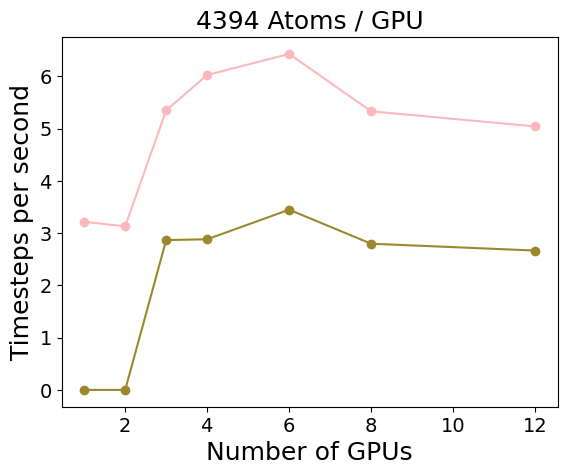

In [19]:
r6_data = json.load(open('data/VCrTiWZr_Scalability_Test/r6_data.json'))
r7_data = json.load(open('data/VCrTiWZr_Scalability_Test/r7_data.json'))
r8_data = json.load(open('data/VCrTiWZr_Scalability_Test/r8_data.json'))

atom_size = 8192 # 1024, 4096, 8192 
# atoms_per_gpu_1024
strong_scaling_r6 = r6_data['weak_scaling'][f'atoms_per_gpu_{atom_size}']
num_gpus_r6 = [int(k.split('_')[1]) for k in strong_scaling_r6.keys()]
print(num_gpus_r6)
time_steps_r6 = [strong_scaling_r6[f'gpus_{gpu}']['timesteps_per_second'] for gpu in num_gpus_r6]
print(time_steps_r6)

strong_scaling_r7 = r7_data['weak_scaling'][f'atoms_per_gpu_{atom_size}']
num_gpus_r7 = [int(k.split('_')[1]) for k in strong_scaling_r7.keys()]
print(num_gpus_r7)
time_steps_r7 = [strong_scaling_r7[f'gpus_{gpu}'].get('timesteps_per_second',0) for gpu in num_gpus_r7]
print(time_steps_r7)

strong_scaling_r8 = r8_data['weak_scaling'][f'atoms_per_gpu_{atom_size}']
num_gpus_r8 = [int(k.split('_')[1]) for k in strong_scaling_r8.keys()]
print(num_gpus_r8)
time_steps_r8 = [strong_scaling_r8[f'gpus_{gpu}'].get('timesteps_per_second', 0) for gpu in num_gpus_r8]
print(time_steps_r8)

real_num_atoms = strong_scaling_r6['gpus_1']['num_atoms']

plt.figure()
plt.title(f"{real_num_atoms} Atoms / GPU",fontsize=18)
plt.plot(num_gpus_r6, time_steps_r6, 'o-', color='#fdb8bd', label='R_max = 6, Num Layers = 1, L_max = 0')
plt.plot(num_gpus_r7, time_steps_r7, 'o-', color='#9c882c', label='R_max = 7, Num Layers = 1, L_max = 1')
#plt.plot(num_gpus_r8, time_steps_r8, 'o-', color='#0d365f', label='R_max = 8, Num Layers = 2, L_max = 1')
plt.xlabel('Number of GPUs',fontsize=18)
plt.ylabel('Timesteps per second',fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=14)  # Set the tick label size for both axes
#plt.legend()
plt.show()

# On Frontier

Extracted Data:
    num_atoms  num_nodes  timesteps_per_sec
0      128000         64             50.396
1      128000          4              6.622
2      128000          1              1.950
3      128000          8             12.391
4      128000         16             21.960
5      128000         32             35.740
6      250000         64             32.788
7      250000          4              3.836
8      250000          1              1.011
9      250000          8              6.743
10     250000         16             12.606
11     250000         32             22.441


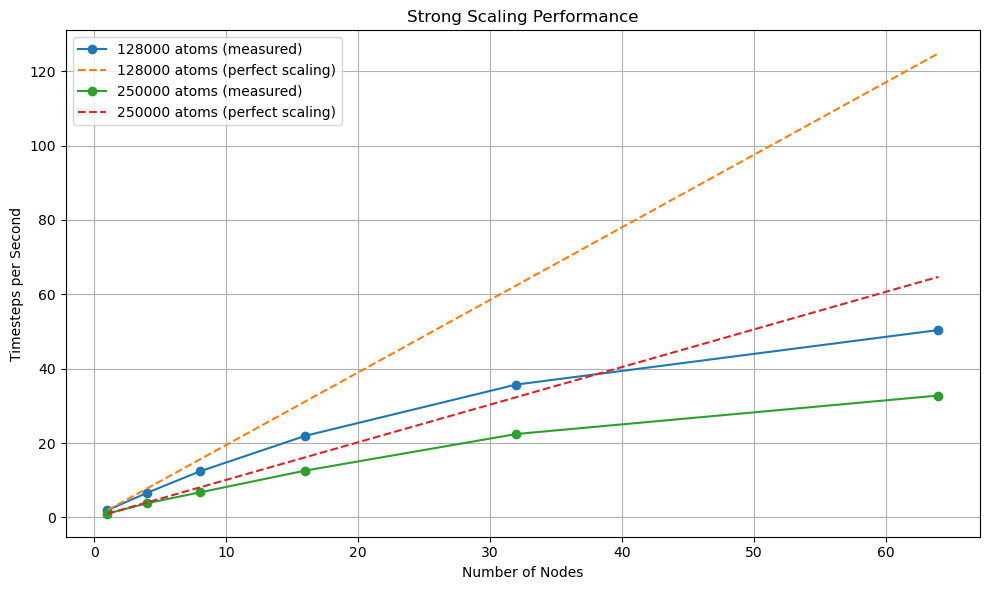

In [1]:
import os
import re
import tarfile
import pandas as pd
import matplotlib.pyplot as plt

# Path to the tar file
#tar_file = "results.tar.gz"

# Extract the tar file
#with tarfile.open(tar_file, "r:gz") as tar:
   # tar.extractall()

results_path = './data/Frontier_Scaling/results'

# The base directory where the results are stored after extraction
base_dir = os.path.join(results_path, "r5_l2_nl1_ntf32_zbl_gen_6")

# List to collect data
data = []

# Iterate over the num_atoms directories (should be '128000' and '250000')
for num_atoms in os.listdir(base_dir):
    atom_dir = os.path.join(base_dir, num_atoms)
    if os.path.isdir(atom_dir):
        # Iterate over the node directories (e.g., "1_Nodes", "4_Nodes", etc.)
        for node_dir in os.listdir(atom_dir):
            node_path = os.path.join(atom_dir, node_dir)
            if os.path.isdir(node_path):
                # Extract the number of nodes from the directory name (e.g., "1_Nodes" -> 1)
                try:
                    num_nodes = int(node_dir.split('_')[0])
                except ValueError:
                    print(f"Skipping directory {node_dir} because it does not match expected pattern.")
                    continue

                log_file = os.path.join(node_path, "log.lammps")
                if os.path.isfile(log_file):
                    with open(log_file, "r") as f:
                        content = f.read()

                    # Extract timesteps/s from the performance line using regex
                    # The line format is like:
                    # "Performance: 3.088 ns/day, 7.772 hours/ns, 35.740 timesteps/s, 4.575 Matom-step/s"
                    match = re.search(r'Performance:.*?([\d.]+)\s*timesteps/s', content)
                    if match:
                        ts = float(match.group(1))
                        data.append({
                            "num_atoms": int(num_atoms),
                            "num_nodes": num_nodes,
                            "timesteps_per_sec": ts
                        })
                    else:
                        print(f"timesteps/s not found in {log_file}")

# Create a DataFrame from the data collected
df = pd.DataFrame(data)
print("Extracted Data:")
print(df)

# Plotting the strong scaling and perfect scaling curves
plt.figure(figsize=(10, 6))

# Loop over each unique atom count and plot the results
for atoms in sorted(df['num_atoms'].unique()):
    subset = df[df['num_atoms'] == atoms].sort_values('num_nodes')
    nodes = subset['num_nodes']
    ts_measured = subset['timesteps_per_sec']
    
    # Use the performance at 1 node as the baseline for perfect scaling
    baseline = subset[subset['num_nodes'] == 1]['timesteps_per_sec'].iloc[0]
    ts_perfect = baseline * nodes

    plt.plot(nodes, ts_measured, marker='o', label=f"{atoms} atoms (measured)")
    plt.plot(nodes, ts_perfect, linestyle='--', label=f"{atoms} atoms (perfect scaling)")

plt.xlabel("Number of Nodes")
plt.ylabel("Timesteps per Second")
plt.title("Strong Scaling Performance")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()